https://www.kaggle.com/datasets/trolukovich/food11-image-dataset


torch version: 2.5.1+cu124
pytorch_lightning version: 2.5.0.post0
ref                                                     title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
asinow/car-price-dataset                                Car Price Dataset                            135KB  2025-01-26 19:53:28          14366        218  1.0              
adilshamim8/sleep-cycle-and-productivity                Sleep Cycle & Productivity                   155KB  2025-02-07 05:44:59           2156         41  1.0              
akxiit/blinkit-sales-dataset                            Blinkit Sales Dataset                          1MB  2025-02-09 12:39:05           1873         30  0.9411765        
abdulmalik1518/mobiles-dataset-2025                     Mobiles Datas

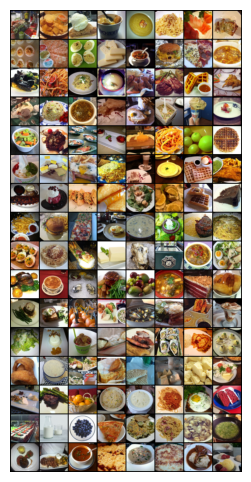

🎉 Dataset loaded and visualized successfully!


In [6]:
# Install required packages
!pip install -q pytorch_lightning kaggle

# Import required libraries
import os
import zipfile
import shutil
import torch
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F

# Display package versions
print("torch version:", torch.__version__)
print("pytorch_lightning version:", pl.__version__)

# Step 1: Setup Kaggle API credentials
kaggle_json_path = "/content/kaggle.json"
kaggle_dir = "/root/.kaggle"
os.makedirs(kaggle_dir, exist_ok=True)

# Move kaggle.json to the correct location
if os.path.exists(kaggle_json_path):
    shutil.move(kaggle_json_path, f"{kaggle_dir}/kaggle.json")
    os.chmod(f"{kaggle_dir}/kaggle.json", 0o600)
else:
    print("⚠️ kaggle.json not found. Please upload it and try again.")
    exit()

# Verify Kaggle access
!kaggle datasets list | head -10

# Step 2: Download the Food11 dataset from Kaggle
dataset_name = "trolukovich/food11-image-dataset"
output_path = "food11-image-dataset.zip"

if not os.path.exists(output_path):
    print("📥 Downloading dataset...")
    os.system(f"kaggle datasets download -d {dataset_name}")
else:
    print("✅ Dataset already downloaded.")

# Step 3: Extract the dataset
dataset_folder = "food"
if not os.path.exists(dataset_folder):
    print("📦 Extracting dataset...")
    with zipfile.ZipFile(output_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_folder)
else:
    print("✅ Dataset already extracted.")

# Step 4: Detect Dataset Paths
def find_dataset_paths(base_dir="food"):
    train_dir, val_dir = None, None
    for root, dirs, _ in os.walk(base_dir):
        if "training" in dirs:
            train_dir = os.path.join(root, "training")
        if "validation" in dirs:
            val_dir = os.path.join(root, "validation")
    return train_dir, val_dir

food_train_directory, food_test_directory = find_dataset_paths()

if not food_train_directory or not food_test_directory:
    print("❌ Training or validation directory not found!")
    exit()

print(f"✅ Training Directory: {food_train_directory}")
print(f"✅ Validation Directory: {food_test_directory}")

# Step 5: Define transformations for images
image_size = 64
batch_size = 128
normalize = [(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]

transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalize)
])

# Step 6: Load datasets
try:
    food_train_dataset = ImageFolder(food_train_directory, transform=transform)
    food_test_dataset = ImageFolder(food_test_directory, transform=transform)

    train_loader = DataLoader(food_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(food_test_dataset, batch_size=batch_size, shuffle=False)

    print(f"✅ Training samples: {len(food_train_dataset)}")
    print(f"✅ Validation samples: {len(food_test_dataset)}")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    exit()

# Step 7: Visualize some images
def denormalize(input_image_tensors):
    input_image_tensors = input_image_tensors * normalize[1][0]
    input_image_tensors = input_image_tensors + normalize[0][0]
    return input_image_tensors

def show_images(images, nrow=8):
    plt.figure(figsize=(12, 6))
    plt.imshow(make_grid(denormalize(images.cpu()), nrow=nrow).permute(1, 2, 0))
    plt.axis("off")
    plt.show()

# Display a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)
show_images(images)

print("🎉 Dataset loaded and visualized successfully!")


In [12]:
import torch
import torch.nn as nn

class FoodDiscriminator(nn.Module):
    def __init__(self, input_size):
        super(FoodDiscriminator, self).__init__()

        self.input_size = input_size
        self.channel = 3
        self.kernel_size = 4
        self.stride = 2
        self.padding = 1
        self.bias = False
        self.negative_slope = 0.2

        # Input size: (3, 64, 64)
        self.conv1 = nn.Conv2d(self.channel, 128, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.LeakyReLU(self.negative_slope, inplace=True)

        # Input size: (128, 32, 32)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias)
        self.bn2 = nn.BatchNorm2d(256)

        # Input size: (256, 16, 16)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias)
        self.bn3 = nn.BatchNorm2d(512)

        # Input size: (512, 8, 8)
        self.conv4 = nn.Conv2d(512, 1024, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias)
        self.bn4 = nn.BatchNorm2d(1024)

        self.fc = nn.Sequential(
            nn.Linear(in_features=1024 * 4 * 4, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, input_img):
        validity = self.conv1(input_img)
        validity = self.bn1(validity)
        validity = self.relu(validity)

        validity = self.conv2(validity)
        validity = self.bn2(validity)
        validity = self.relu(validity)

        validity = self.conv3(validity)
        validity = self.bn3(validity)
        validity = self.relu(validity)

        validity = self.conv4(validity)
        validity = self.bn4(validity)
        validity = self.relu(validity)

        # Flatten the tensor before the fully connected layer
        validity = validity.view(-1, 1024 * 4 * 4)
        validity = self.fc(validity)
        return validity


In [13]:
class FoodGenerator(nn.Module):
    def __init__(self, latent_size = 256):
        super().__init__()
        self.latent_size = latent_size
        self.kernel_size = 4
        self.stride = 2
        self.padding = 1
        self.bias = False

        self.model = nn.Sequential(

              #input size: (latent_size,1,1)
              nn.ConvTranspose2d(latent_size, 512, kernel_size=self.kernel_size, stride=1, padding=0, bias=self.bias),
              nn.BatchNorm2d(512),
              nn.ReLU(True),

              #input size: (512,4,4)
              nn.ConvTranspose2d(512, 256, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.BatchNorm2d(256),
              nn.ReLU(True),

              #input size: (256,8,8)
              nn.ConvTranspose2d(256, 128, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.BatchNorm2d(128),
              nn.ReLU(True),

              #input size: (128,16,16)
              nn.ConvTranspose2d(128, 64, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.BatchNorm2d(64),
              nn.ReLU(True),

              nn.ConvTranspose2d(64, 3, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.Tanh()
              # output size: 3 x 64 x 64
        )

    def forward(self, input_img):
        input_img = self.model(input_img)
        return input_img

In [14]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import os
from torchvision.utils import save_image

ALL_FOOD_IMAGES = []

def save_generated_samples(epoch, sample_images, output_dir="food_generated_images"):
    os.makedirs(output_dir, exist_ok=True)
    fname = os.path.join(output_dir, f"generated-images-{epoch}.png")
    save_image(sample_images[:64], fname, nrow=8, normalize=True)

class FoodGAN(pl.LightningModule):
    def __init__(self, latent_size=256, learning_rate=0.0002, bias1=0.5, bias2=0.999, batch_size=128):
        super(FoodGAN, self).__init__()
        self.automatic_optimization = False
        self.save_hyperparameters()

        self.generator = FoodGenerator()
        self.discriminator = FoodDiscriminator(input_size=64)

        self.latent_size = latent_size
        self.batch_size = batch_size
        self.validation_noise = torch.randn(self.batch_size, self.latent_size, 1, 1)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, preds, targets):
        return nn.BCELoss()(preds, targets)

    def training_step(self, batch, batch_idx):
        real_images, _ = batch
        device = real_images.device

        # Get optimizers
        opt_g, opt_d = self.optimizers()

        # Train Generator
        opt_g.zero_grad()
        noise = torch.randn(self.batch_size, self.latent_size, 1, 1).to(device)
        fake_images = self(noise)
        preds = self.discriminator(fake_images)
        g_loss = self.adversarial_loss(preds, torch.ones_like(preds))
        self.manual_backward(g_loss)
        opt_g.step()

        self.log("generator_loss", g_loss, prog_bar=True, logger=True)

        # Train Discriminator
        opt_d.zero_grad()

        # Real images
        real_preds = self.discriminator(real_images)
        real_loss = self.adversarial_loss(real_preds, torch.ones_like(real_preds))

        # Fake images
        fake_images = self(noise).detach()
        fake_preds = self.discriminator(fake_images)
        fake_loss = self.adversarial_loss(fake_preds, torch.zeros_like(fake_preds))

        # Total discriminator loss
        d_loss = real_loss + fake_loss
        self.manual_backward(d_loss)
        opt_d.step()

        self.log("discriminator_loss", d_loss, prog_bar=True, logger=True)

        return {"g_loss": g_loss, "d_loss": d_loss}

    def configure_optimizers(self):
        learning_rate = self.hparams.learning_rate
        bias1 = self.hparams.bias1
        bias2 = self.hparams.bias2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=learning_rate, betas=(bias1, bias2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate, betas=(bias1, bias2))

        return [opt_g, opt_d], []

    def on_train_epoch_end(self):
        z = self.validation_noise.to(self.device)
        with torch.no_grad():
            sample_imgs = self(z)
        ALL_FOOD_IMAGES.append(sample_imgs.cpu())
        save_generated_samples(self.current_epoch, sample_imgs)


In [15]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),        # Convert images to tensors
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1] range
])

# Dataset path
dataset_path = "food/training"

# Check if dataset path exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"❌ Dataset path '{dataset_path}' not found. Please verify the directory structure.")

# Load the dataset
train_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create DataLoader
food_train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

# Output dataset info
print(f"✅ Dataset loaded successfully!")
print(f"📊 Total training samples: {len(train_dataset)}")
print(f"🖼️ Classes: {train_dataset.classes}")



✅ Dataset loaded successfully!
📊 Total training samples: 9866
🖼️ Classes: ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os
import time


class FoodGAN:
    def __init__(self, latent_size=256, lr=0.0002, betas=(0.5, 0.999), batch_size=128, device='cuda'):
        self.device = device
        self.latent_size = latent_size
        self.batch_size = batch_size

        # Initialize networks
        self.generator = FoodGenerator().to(device)
        self.discriminator = FoodDiscriminator(input_size=64).to(device)

        # Optimizers
        self.opt_g = optim.Adam(self.generator.parameters(), lr=lr, betas=betas)
        self.opt_d = optim.Adam(self.discriminator.parameters(), lr=lr, betas=betas)

        # Loss function
        self.criterion = nn.BCELoss()

        # Fixed noise for validation
        self.validation_noise = torch.randn(batch_size, latent_size, 1, 1, device=device)

        # History tracking
        self.all_food_images = []
        self.g_losses = []
        self.d_losses = []

    def adversarial_loss(self, preds, targets):
        return self.criterion(preds, targets)

    def train_epoch(self, dataloader):
        self.generator.train()
        self.discriminator.train()

        for real_images, _ in dataloader:
            real_images = real_images.to(self.device)
            batch_size = real_images.size(0)

            # ---------------------
            #  Train Generator
            # ---------------------
            self.opt_g.zero_grad()

            # Generate fake images
            noise = torch.randn(batch_size, self.latent_size, 1, 1, device=self.device)
            fake_images = self.generator(noise)

            # Generator loss
            preds = self.discriminator(fake_images)
            g_loss = self.adversarial_loss(preds, torch.ones(batch_size, 1, device=self.device))
            g_loss.backward()
            self.opt_g.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------
            self.opt_d.zero_grad()

            # Real images loss
            real_preds = self.discriminator(real_images)
            real_loss = self.adversarial_loss(real_preds, torch.ones(batch_size, 1, device=self.device))

            # Fake images loss (reuse generated images)
            fake_preds = self.discriminator(fake_images.detach())
            fake_loss = self.adversarial_loss(fake_preds, torch.zeros(batch_size, 1, device=self.device))

            d_loss = real_loss + fake_loss
            d_loss.backward()
            self.opt_d.step()

            # Save losses
            self.g_losses.append(g_loss.item())
            self.d_losses.append(d_loss.item())

    def generate_samples(self, epoch):
        self.generator.eval()
        with torch.no_grad():
            sample_imgs = self.generator(self.validation_noise)
            self.all_food_images.append(sample_imgs.cpu())
            save_generated_samples(epoch, sample_imgs)

def save_generated_samples(epoch, sample_images, output_dir="food_generated_images"):
    os.makedirs(output_dir, exist_ok=True)
    fname = os.path.join(output_dir, f"generated-images-{epoch}.png")
    save_image(sample_images[:64], fname, nrow=8, normalize=True)

# Training execution
if __name__ == "__main__":
    # Hyperparameters
    latent_size = 256
    batch_size = 128
    num_epochs = 50  # 300 bayad bashad
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Initialize model
    model = FoodGAN(latent_size=latent_size, batch_size=batch_size, device=device)

    # Training loop
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train_epoch(food_train_dataloader)
        model.generate_samples(epoch)

        # Print progress
        avg_g_loss = sum(model.g_losses[-len(food_train_dataloader):]) / len(food_train_dataloader)
        avg_d_loss = sum(model.d_losses[-len(food_train_dataloader):]) / len(food_train_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} | G Loss: {avg_g_loss:.4f} | D Loss: {avg_d_loss:.4f}")

    total_time = time.time() - start_time
    print(f"Training completed in {total_time/60:.2f} minutes")

Epoch 1/50 | G Loss: 10.5483 | D Loss: 0.7678
Epoch 2/50 | G Loss: 3.6286 | D Loss: 0.4388
Epoch 3/50 | G Loss: 3.2697 | D Loss: 0.5676
Epoch 4/50 | G Loss: 3.7825 | D Loss: 0.4108
Epoch 5/50 | G Loss: 4.8206 | D Loss: 0.3798
Epoch 6/50 | G Loss: 3.9212 | D Loss: 0.3077
Epoch 7/50 | G Loss: 4.0006 | D Loss: 0.3682
Epoch 8/50 | G Loss: 3.7955 | D Loss: 0.3813
Epoch 9/50 | G Loss: 4.0312 | D Loss: 0.2915
Epoch 10/50 | G Loss: 3.8365 | D Loss: 0.3715
Epoch 11/50 | G Loss: 3.7603 | D Loss: 0.3664
Epoch 12/50 | G Loss: 3.4324 | D Loss: 0.4873
Epoch 13/50 | G Loss: 3.3727 | D Loss: 0.4049
Epoch 14/50 | G Loss: 4.0299 | D Loss: 0.3550
Epoch 15/50 | G Loss: 3.6477 | D Loss: 0.3589
Epoch 16/50 | G Loss: 3.6974 | D Loss: 0.2808
Epoch 17/50 | G Loss: 3.7458 | D Loss: 0.3063
Epoch 18/50 | G Loss: 4.1954 | D Loss: 0.4539
Epoch 19/50 | G Loss: 3.9443 | D Loss: 0.3912
Epoch 20/50 | G Loss: 3.7136 | D Loss: 0.3443
Epoch 21/50 | G Loss: 3.6763 | D Loss: 0.3673
Epoch 22/50 | G Loss: 4.2138 | D Loss: 0.4

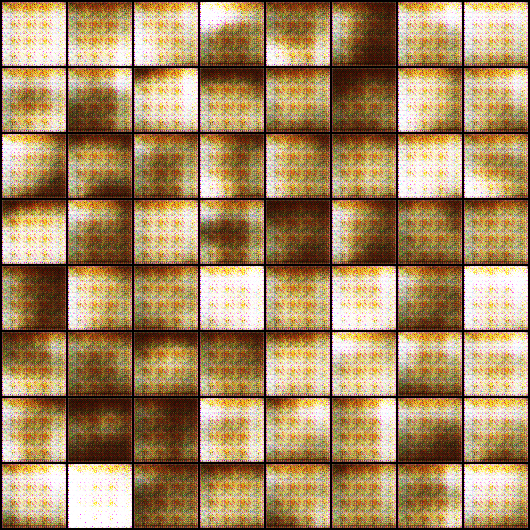

In [17]:
from IPython.display import Image
Image('food_generated_images/generated-images-1.png')

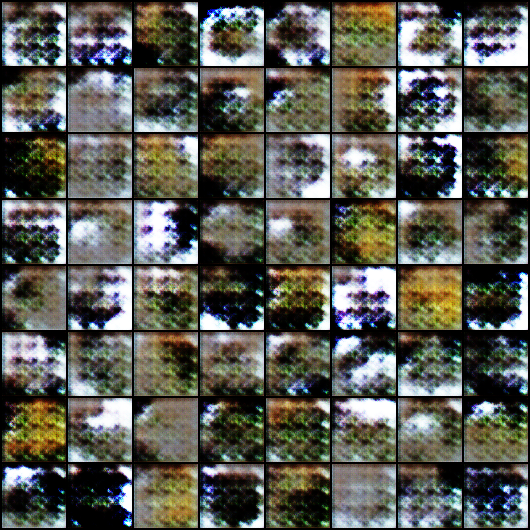

In [18]:
import os
from PIL import Image
import IPython.display as display

image_path = "food_generated_images/generated-images-9.png"

if os.path.exists(image_path):
    display.display(Image.open(image_path))
else:
    print(f"❌ Image not found: {image_path}")

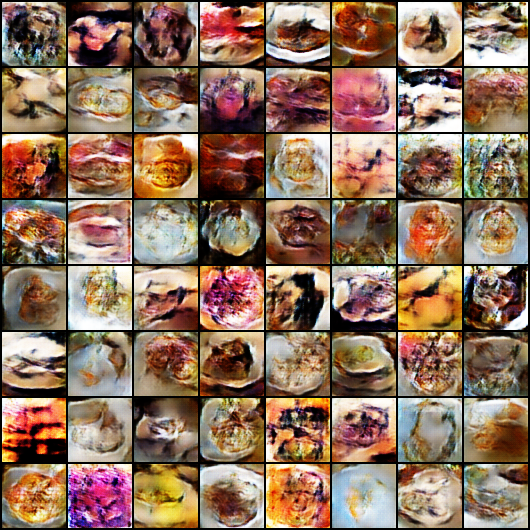

In [20]:
from IPython.display import Image
Image('food_generated_images/generated-images-49.png')